<center><h1>Mini Project 5</h1></center>
<center><h2>Watchanan Chantapakul (<a href="mailto:wcgzm@umsystem.edu"><code>wcgzm</code></a>)</h2></center>
<hr />

This question is to demonstrate that: 1) when the selected model is poor, the maximum-likelihood classifier does not produce satisfactory results; and 2) proper transformation of the data can compensate for poor models. The dataset[<sup>1</sup>](#fn1) used for this question is divided into training[<sup>2</sup>](#fn2) and test[<sup>3</sup>](#fn3) data, with each one consisting of 3 classes in a 2D-feature space.

- a) Assuming Gaussian distribution for all three class conditional densities, and with unknown means and covariances, compute the **maximum likelihood estimates** for each class using the training data.
- b) Ignore the priors, i.e. assume 1/3 for all three classes, and redo parts a) and b) of MiniProject 2, Question 1, and use those same Matlab functions in part c) below. Use the means and variances from part a) above.
- c) Classify the test data and compute the test error using confusion matrix[<sup>4</sup>](#fn4).
- d) **Bayesian estimates**. The data has a simpler description when seen in polar coordinates. Use *cart2pol()* to transform all the data points to polar coordinates. Use scatter() to plot the transformed points. What you should find is that the transformed data looks Gaussian on the radius r and uniform on the angle $\theta$. So, ignore the angle $\theta$ and classify the test data only on r as
follows.

The problem is now 1-D and again, if you inspect the data, Gaussian distribution is a more suitable pdf to describe all three classes. Assume then that each class has $p(r|\omega_i) = \mathcal{N}(\mu_i, \sigma^2)$ with $\mu_i$ unknown and variance $\sigma^2 = 0.25$ for all three classes. Let the only prior knowledge about $\mu_i$ be $p(\mu_i) = \mathcal{N}(\mu_0 = 0, \sigma_0^2 = 100)$ and compute the Bayes estimates for $\mu_i$ and the posterior distribution $p(\mu_i|D_i)$ of all three classes. Next compute $p(r|\omega_i,D_i) = \int p(r|\mu_i) p(\mu_i|D_i) \,d\mu_i$ and use this density estimate to classify the test data and compute the test error using confusion matrix.

**Do not forget to comment on the results from each step above.**
<br /><br />
<span id="fn1"><sup>1</sup> http://vigir.missouri.edu/~gdesouza/ece7720/test_train_data_class3.mat</span><br />
<span id="fn2"><sup>2</sup> access the training data by TrainPts = Data.train</span><br />
<span id="fn3"><sup>3</sup> access the test data by TestPts = Data.test</span><br />
<span id="fn4"><sup>4</sup> http://vigir.missouri.edu/~gdesouza/ece7720/Lecture_Notes/Lecture10.pdf</span><br />

<hr />

In [1]:
%matplotlib inline

import os

import numpy as np
import sympy
import scipy
import scipy.io

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math

np.random.seed(7720)

In [2]:
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['savefig.dpi'] = 600

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
def show(text, ans, precision=4):
    if type(ans) == np.ndarray:
        t = r'\begin{bmatrix} '
        for i in ans:
#             print(i, type(i))
#             print(r' \\ '.join(i))
            if type(i) != np.ndarray:
                t += f'{i:.4f}' + r' \\ '
            else:
                a_str = np.array2string(i, precision=precision, separator=r' & ')
                t += a_str[1:-1]
                t += r' \\ '
        t += r'\end{bmatrix}'
        display(Math(f'{text} = {t}'))
    else:
        display(Math(f'{text} = {ans:.{precision}f}'))

## Dataset

Load data from the `test_train_data_class3.mat` file. The customized `loadmat` function of scipy is needed here as the original `loadmat` function cannot cope with nested dictionaries.

In [5]:
# credit: https://stackoverflow.com/a/29126361/7150241
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.io.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [6]:
mat = loadmat(os.path.join("data", "test_train_data_class3.mat"))

In [7]:
mat['Data'].keys()

dict_keys(['test', 'train'])

The stored `Data` variable contains two subsets including *test* and *train*.

In [8]:
train_mat = mat['Data']['train']
test_mat = mat['Data']['test']

We dig deeper into the number of classes and the number of dimensions.

In [9]:
C = len(train_mat)
d = len(train_mat[0])
print(f'C = {C} classes')
print(f'd = {d} dimensions')

C = 3 classes
d = 2 dimensions


In [10]:
train_data, test_data = [], []

for c in range(C):
    train_data.append(np.array(train_mat[c]).T)
    test_data.append(np.array(test_mat[c]).T)

In [11]:
for c in range(C):
    print(f'[train]\tclass {c+1} = {len(train_data[c])} samples')
    print(f'[test]\tclass {c+1} = {len(test_data[c])} samples')
    print('-' * 30)

[train]	class 1 = 30 samples
[test]	class 1 = 70 samples
------------------------------
[train]	class 2 = 50 samples
[test]	class 2 = 94 samples
------------------------------
[train]	class 3 = 20 samples
[test]	class 3 = 46 samples
------------------------------


### Data Visualization

In [12]:
def plot_2d_features(data, mu=None, cov=None, title="", x_label="$x_1$", y_label="$x_2$"):
    sample_colors = ('deepskyblue', 'hotpink', 'mediumseagreen')
    sample_markers = ('o', 's', '^')
    mean_colors = ('blue', 'deeppink', 'green')

    fig, ax = plt.subplots(figsize=(8, 8))

    for c in range(C):
        # samples
        ax.scatter(data[c][:, 0], data[c][:, 1], color=sample_colors[c], marker=sample_markers[c], label=f"$\omega_{c+1}$")
        
        # means
        if mu is not None:
            ax.scatter(mu[c][0], mu[c][1], color=mean_colors[c], marker='X', s=100, edgecolor='black', label=r"$\vec{\mu}_" + str(c+1) + "$")

        # covariances
        if cov is not None:
            eigval, eigvec = np.linalg.eig(cov[c])
            std_values = eigval

            major_idx = np.argmax(eigval)
            minor_idx = 1 if major_idx == 0 else 0

            alpha = np.arctan2(eigvec[1, major_idx], eigvec[0, major_idx])
            major_r_x = std_values[major_idx]
            major_r_y = std_values[minor_idx]

            theta = np.linspace(0, 2*np.pi, 100)
            mean_x, mean_y = mu[c]
            e_X = major_r_x * np.cos(theta) * np.cos(alpha) - major_r_y * np.sin(theta) * np.sin(alpha) + mean_x
            e_Y = major_r_x * np.cos(theta) * np.sin(alpha) + major_r_y * np.sin(theta) * np.cos(alpha) + mean_y
            ax.plot(e_X, e_Y, color=mean_colors[c], linestyle="--")

            # legends
            handles, labels = ax.get_legend_handles_labels()
            handles.append(Line2D([0], [0], color="gray", linewidth=3, linestyle='--'))
            labels.append("$\sigma_{j}^2$")

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_aspect(1)
    if cov is None:
        handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})

    plt.close(fig)
    return fig

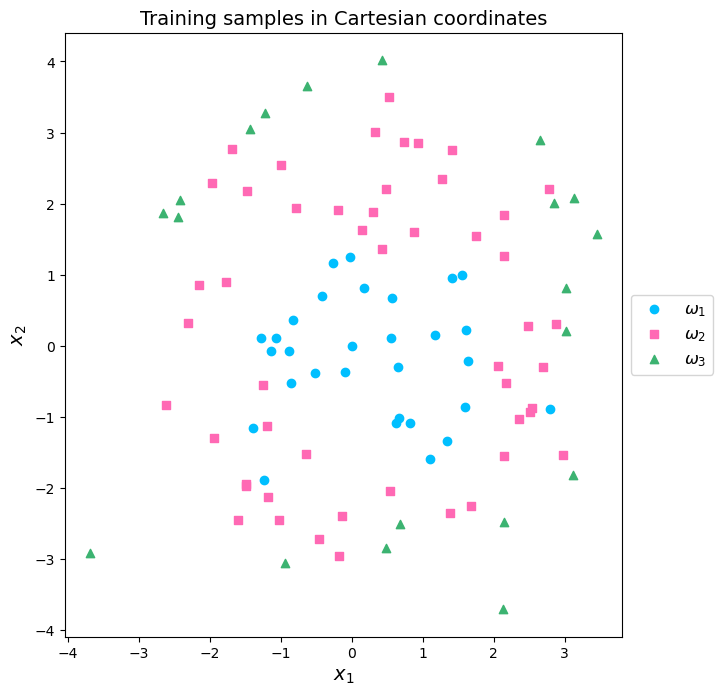

In [13]:
plot_2d_features(train_data, title="Training samples in Cartesian coordinates")

## Maximum Likelihood Estimation (MLE)

Assume that the **class-conditional densities** $p(\mathbf{x}|\omega_i)$ are in the form of Gaussian distribution with unknown parameters, means $\mathbf{\mu}_i$ and covariance matrices $\mathbf{\Sigma}_i$. But we can estimate those parameters by using a method called maximum likelihood estimation (MLE) on the given training data.

From the training data, we have $C=3$ classes. Thus, there are 3 sets, $D_1, D_2,$ and $D_3$. All samples in each set are i.i.d. (independent and identically distributed). Also, we use the samples in $D_i$ only to estimate $\theta_i$ without interfering with other classes.

There are $n_i$ samples, $x_1, \dots, x_{n_i}$, in $D_i$

### Log-likelihood $\ln p(x_k | \mathbf{\theta})$

Since the data are in 2D space, the class-conditional densities are **multivariate Gaussian** distribution with the following parameters $\vec{\theta}$:
- $\theta_1 = \mu$ (mean)
- $\theta_2 = \Sigma$ (covariance matrix)

Our log-likelihood $\ln p(x_k | \vec{\theta})$ of a single sample $x_k$ is then defined as:

$$
\ln p(x_k | \vec{\theta}) = -\frac{1}{2}(x_k-\mu_i)^\mathsf{T}\Sigma_i^{-1}(x_k-\mu_i) -\frac{d}{2}\ln (2\pi) - \frac{1}{2} \ln |\Sigma_i| + \ln P(\omega_i)
$$

In [14]:
def log_likelihood(x, mean, cov, prior):
    d = len(x)
    A = -0.5 * ((mahalanobis_distance(x, mean, cov)) ** 2)
    B = - ((d/2) * np.log(2 * np.pi))
    C = - (0.5 * np.log(determinant(cov))) + np.log(prior)
    return A + B + C

Log-likelihood $l$ of the dataset $D = [x_1, \dots, x_{n_i}]$ is:
$$
l(\vec{\theta}) = \sum_{k=1}^{n} \ln p(x_k | \vec{\theta})
$$

We arrive at the gradients or the derivatives of the log-likelihood $l$ w.r.t. $\vec{\theta} = [\theta_1\ \theta_2]^{\mathsf{T}}$ as follows:
$$
\nabla_{\vec{\theta}} l = \sum_{k=1}^{n} \nabla_{\vec{\theta}} \ln p(x_k | \vec{\theta})
$$

To estimate $\vec{\theta}$, we set the gradients to be zero to obtain the maximum likelihood estimate of $\vec{\theta}$,
$$
\nabla_{\vec{\theta}} l = \vec{0}
$$


$$
\nabla_{\vec{\theta}} l = 
\begin{bmatrix}
\frac{\partial l}{\partial \theta_1}\\
\frac{\partial l}{\partial \theta_2}
\end{bmatrix}
$$

#### Estimate $\theta_1 = \mu$

$$
\frac{\partial l}{\partial \theta_1}
= \frac{\partial l}{\partial \mu}
= \frac{\partial}{\partial \mu} \left( \sum_{k=1}^{n} -\frac{1}{2}(x_k-\mu_i)^\mathsf{T}\Sigma_i^{-1}(x_k-\mu_i) \right)
= \vec{0}
$$

$$
\frac{\partial}{\partial \mu} \left( \sum_{k=1}^{n} (x_k-\mu_i)^\mathsf{T}\Sigma_i^{-1}(x_k-\mu_i) \right)
= \vec{0}
$$

$$
\frac{\partial}{\partial \mu} \left( \sum_{k=1}^{n}
(x_k^{\mathsf{T}}\Sigma_i^{-1}-\mu_i^{\mathsf{T}}\Sigma_i^{-1}) (x_k-\mu_i)
\right)
= \vec{0}
$$

$$
\frac{\partial}{\partial \mu} \left( \sum_{k=1}^{n}
(x_k^{\mathsf{T}}\Sigma_i^{-1}x_k - 2\mu_i^{\mathsf{T}}\Sigma_i^{-1}x_k + \mu_i^{\mathsf{T}} \Sigma_i^{-1} \mu_i)
\right)
= \vec{0}
$$

$$
\sum_{k=1}^{n}
(0 - 2\Sigma_i^{-1}x_k + 2 \Sigma_i^{-1} \mu_i)
= \vec{0}
$$

$$
\sum_{k=1}^{n}
(- \Sigma_i^{-1}x_k + \Sigma_i^{-1} \mu_i)
= \vec{0}
$$

$$
\sum_{k=1}^{n}
(\Sigma_i^{-1} \mu_i - \Sigma_i^{-1}x_k)
= \vec{0}
$$

$$
\sum_{k=1}^{n}
\left(\Sigma_i^{-1} (\mu_i - x_k) \right)
= \vec{0}
$$

$$
\Sigma_i^{-1}
\sum_{k=1}^{n}
\left(\mu_i - x_k \right)
= \vec{0}
$$

Multiplying both sides by $\Sigma$,
$$
\sum_{k=1}^{n}
\left(\mu_i - x_k \right)
= \vec{0}
$$

$$
n \mu_i - \sum_{k=1}^{n} x_k
= \vec{0}
$$

$$
\mu_i = \frac{1}{n} \sum_{k=1}^{n} x_k
$$

In [15]:
def compute_mean(X, axis=0):
    return np.sum(X, axis=axis) / len(X)

In [16]:
mu = np.zeros((C, d))
for c in range(C):
    mu[c] = compute_mean(train_data[c])
    show(r'\vec{\mu}_' + str(c+1), mu[c])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [17]:
np_mu = np.zeros((C, d))
for c in range(C):
    np_mu[c] = np.mean(train_data[c])
    show(r'\mathrm{Numpy}\ \vec{\mu}_' + str(c+1), np_mu[c])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
print("np.mean == compute_mean?", np.allclose(np_mu, mu))

np.mean == compute_mean? False


#### Estimate $\theta_2 = \Sigma$

This is a biased estimate for a covariance matrix $\Sigma_i$.

$$
\frac{\partial l}{\partial \theta_2}
= \frac{\partial l}{\partial \Sigma}
= \frac{\partial}{\partial \Sigma} \left( \sum_{k=1}^{n} \left( -\frac{1}{2}(x_k-\mu_i)^\mathsf{T}\Sigma_i^{-1}(x_k-\mu_i) - \frac{1}{2} \ln |\Sigma_i| \right) \right)
= \vec{0}
$$

$$
\frac{\partial}{\partial \Sigma} \left( \sum_{k=1}^{n} \left( (x_k-\mu_i)^\mathsf{T}\Sigma_i^{-1}(x_k-\mu_i) + \ln |\Sigma_i| \right) \right)
= \vec{0}
$$

As the determinant of the inverse of a matrix is the inverse of the determinant, we arrive at:

$$
\frac{\partial}{\partial \Sigma} \left( \sum_{k=1}^{n} \left( (x_k-\mu_i)^\mathsf{T}\Sigma_i^{-1}(x_k-\mu_i) + \ln |\Sigma_i^{-1}| \right) \right)
= \vec{0}
$$

$$
\sum_{k=1}^{n} \left( -(x_k-\mu_i)(x_k-\mu_i)^\mathsf{T} + \frac{1}{\Sigma_i^{-1}} \right)
= \vec{0}
$$

$$
- \sum_{k=1}^{n} \left((x_k-\mu_i)(x_k-\mu_i)^\mathsf{T} \right) + n\Sigma_i
= \vec{0}
$$

Thus, we can estimate a covariance matrix $\Sigma_i$ with

$$
\Sigma_i
= \frac{1}{n} \sum_{k=1}^{n} \left((x_k-\mu_i)(x_k-\mu_i)^\mathsf{T} \right) 
$$

In [19]:
def transpose(m):
    if type(m[0]) not in (list, np.ndarray):
        return m
    return list(map(list,zip(*m)))

In [20]:
def compute_covariance_matrix(X, mean, bias_term=0):
    cov = np.zeros((len(mean), len(mean)))
    for x in X:
        a = np.array(x) - np.array(mean)
        cov += a[:, None] @ transpose(a)[None, :]
    cov /= len(X) - bias_term
    return cov

In [21]:
cov = np.zeros((C, d, d))
for c in range(C):
    cov[c] = compute_covariance_matrix(train_data[c], mu[c])
    show(r'\mathbf{\Sigma}_' + str(c+1), cov[c])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Cross-check with the Numpy's built-in function `np.cov`

In [22]:
np_cov = np.zeros((C, d, d))
for c in range(C):
    np_cov[c] = np.cov(train_data[c].T, bias=True)
    show(r'\mathrm{Numpy}\ \mathbf{\Sigma}_' + str(c+1), np_cov[c])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
print("[biased] np.cov == compute_covariance_matrix?", np.allclose(np_cov, cov))

[biased] np.cov == compute_covariance_matrix? True


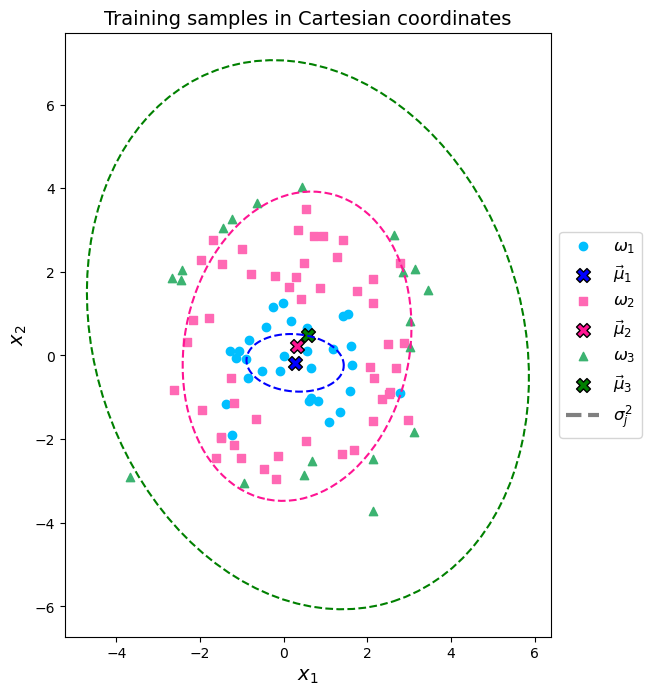

In [24]:
plot_2d_features(train_data, mu, cov, title="Training samples in Cartesian coordinates")

## Classification

Since we don't know anything a priori, the **priors** $P(\omega_i)$ for all classes are uninformative or equally probable with probability of $\frac{1}{3}$ each.

In [25]:
priors = [1/3, 1/3, 1/3]

### Discriminant function $g_i(\cdot)$

From MiniProject 2, the discriminant function with the following generic form is given by:
$$ g_i(x) = -\frac{1}{2}(x-\mu_i)^t\Sigma_i^{-1}(x-\mu_i)-\frac{d}{2}\ln (2\pi) - \frac{1}{2} \ln |\Sigma_i| + \ln P(\omega_i) $$
also for any given $d$ dimensional data, mean, covariance matrix and prior probabilities.

<u>Note</u>: these below functions are from MiniProject 2.

In [26]:
def determinant(A):
    if len(A) == 2:
        det = (A[0][0] * A[1][1]) - (A[1][0] * A[0][1])
        return det

In [27]:
def inverse_matrix(A):
    if len(A) == 2:
        inv_A = [
            [A[1][1], -A[0][1]],
            [-A[1][0], A[0][0]]
        ]
        return np.array(inv_A) / determinant(A)

In [28]:
def identity(N):
    I = np.zeros((N, N), dtype=int)
    for i in range(N):
        I[i, i] = 1
    return I

In [29]:
def mahalanobis_distance(x, y, cov):
    a = np.array(x) - np.array(y)
    r2 = transpose(a) @ inverse_matrix(cov) @ a
    return np.sqrt(r2)

In [30]:
def discriminant_fx(x, mean, cov, prior):
    d = len(x)
    A = -0.5 * ((mahalanobis_distance(x, mean, cov)) ** 2)
    B = - ((d/2) * np.log(2 * np.pi))
    C = - (0.5 * np.log(determinant(cov))) + np.log(prior)
    return A + B + C

#### Classification Rule

We predict the class of a sample $\vec{x}$ based on the following equation:

$$
\hat{y}(\vec{x}) = \operatorname*{argmax}_{i} g_i(\vec{x})
$$

In [31]:
confusion_matrix = np.zeros((C, C))

for c in range(C):
    for x in test_data[c]:
        g = np.zeros(C)
        for i in range(C):
            g[i] = discriminant_fx(x, mu[i], cov[i], priors[i])
        pred_class = np.argmax(g)
        confusion_matrix[c][pred_class] += 1

### Confusion Matrix

Confusion matrix is a tool that we can use to see the performance of a classifier. It is simply a table.

In [32]:
confusion_matrix

array([[59., 11.,  0.],
       [15., 61., 18.],
       [ 0.,  7., 39.]])

| | (predicted) 1 | (predicted) 2 | (predicted) 3 |
| :-: | :-: | :-: | :-: |
|<b>(actual) 1</b>|59|11|0|
|<b>(actual) 2</b>|15|61|18|
|<b>(actual) 3</b>|0|7|39|
<center>Table 1: Confusion matrix of the model with the estimated parameter $\mu_i$ and $\Sigma_i$ using Maximum Likelihood Estimation</center>

According to the confusion matrix shown above, most of the samples are classified correctly. They are placed in the diagonal of the confusion matrix. On the other hand, there are misclassified samples that are off-diagonal of the confusion matrix.

- 11 samples are classified as class 2 but actually they are from class 1
- 15 samples are classified as class 1 but actually they are from class 2
- 7 samples are classified as class 2 but actually they are from class 3

We can compute an accuracy out of the confusion matrix $\mathbf{CM}$ as follows:

$$
\mathrm{Accuracy}
= \operatorname{tr}(\mathbf{CM})
= \frac{\sum_{i=1}^{C} \mathbf{CM}_{ii}}{\sum_{i=1}^{C}\sum_{j=1}^{C} \mathbf{CM}_{ij}}
= \frac{1}{N} \sum_{i=1}^{C} \mathbf{CM}_{ii}
$$

Obviously, we can also calculate an error by subtracting the accuracy from 1.

$$
\mathrm{Error} = 1 - \mathrm{Accuracy}
$$

In [33]:
accuracy = confusion_matrix.trace() / confusion_matrix.sum()
error = 1 - accuracy

show('\mathrm{Test\ Accuracy}', accuracy)
show('\mathrm{Test\ Error}', error)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can achieve the test accuracy of up to $75.71\%$ which also results in the test error of $24.29\%$.

## Unbiased Covariance Matrix

Since the above case, the estimated covariance matrices are biased by nature. It is also interesting to see how unbiased covariance matrices differ from the biased ones. Thus, we can estimate an unbiased covariance matrix $\Sigma_i$ with


$$
\Sigma_i
= \frac{1}{n-1} \sum_{k=1}^{n} \left((x_k-\mu_i)(x_k-\mu_i)^\mathsf{T} \right) 
$$

In [34]:
unbiased_cov = np.zeros((C, d, d))
for c in range(C):
    unbiased_cov[c] = compute_covariance_matrix(train_data[c], mu[c], bias_term=1)
    show(r'\mathrm{Unbiased}\ \mathbf{\Sigma}_' + str(c+1), unbiased_cov[c])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [35]:
np_unbiased_cov = np.zeros((C, d, d))
for c in range(C):
    np_unbiased_cov[c] = np.cov(train_data[c].T, bias=False)
    show(r'\mathrm{Unbiased\ Numpy}\ \mathbf{\Sigma}_' + str(c+1), np_unbiased_cov[c])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [36]:
print("[unbiased] np.cov == compute_covariance_matrix?", np.allclose(np_unbiased_cov, unbiased_cov))

[unbiased] np.cov == compute_covariance_matrix? True


In [37]:
unbiased_confusion_matrix = np.zeros((C, C))

for c in range(C):
    for x in test_data[c]:
        g = np.zeros(C)
        for i in range(C):
            g[i] = discriminant_fx(x, mu[i], unbiased_cov[i], priors[i])
        pred_class = np.argmax(g)
        unbiased_confusion_matrix[c][pred_class] += 1

In [38]:
unbiased_confusion_matrix

array([[59., 11.,  0.],
       [17., 62., 15.],
       [ 0.,  7., 39.]])

| | (predicted) 1 | (predicted) 2 | (predicted) 3 |
| :-: | :-: | :-: | :-: |
|<b>(actual) 1</b>|59|11|0|
|<b>(actual) 2</b>|15|61|18|
|<b>(actual) 3</b>|0|7|39|
<center>Table 2: Confusion matrix of the model with the estimated parameter $\mu_i$ and <strong>unbiased</strong> $\Sigma_i$ using Maximum Likelihood Estimation</center>

Well, the results from using biased and unbiased covariance matrices are different a little bit. Some noticeable changes are as follows:

- The number of samples are classified as class 1 but actually they are from class 2: changed from 15 to 17
- The number of samples are classified as class 2 and actually they are from class 2: increased from 61 to 62
- The number of samples are classified as class 3 but actually they are from class 2: changed from 18 to 15

Obviously, the test samples that are affected are only from class 2.

In [39]:
unbiased_accuracy = unbiased_confusion_matrix.trace() / unbiased_confusion_matrix.sum()
unbiased_error = 1 - unbiased_accuracy

show('\mathrm{[Unbiased]\ Test\ Accuracy}', unbiased_accuracy)
show('\mathrm{[Unbiased]\ Test\ Error}', unbiased_error)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Well, the good news is the test accuracy from using the unbiased covariance matrices are increased by $0.48\%$ (from $75.71\%$ to $76.19\%$). Therefore, the test error also decreases by the same amount.

## Bayesian Estimation

Here, we transform the data by converting them from Cartesian Coordinates $(x, y)$ to Polar Coordinates $(r, \theta)$ using the `cart2pol` function below.

In [40]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return rho, theta

In [41]:
transformed_train_data, transformed_test_data = [], []

for c in range(C):
    rho, theta = cart2pol(train_data[c][:, 0], train_data[c][:, 1])
    transformed_train_data.append(np.vstack((rho, theta)).T)
    
    rho, theta = cart2pol(test_data[c][:, 0], test_data[c][:, 1])
    transformed_test_data.append(np.vstack((rho, theta)).T)

Let's visualize the transformed training samples in polar coordinates. The scatter plot of them are shown below. 

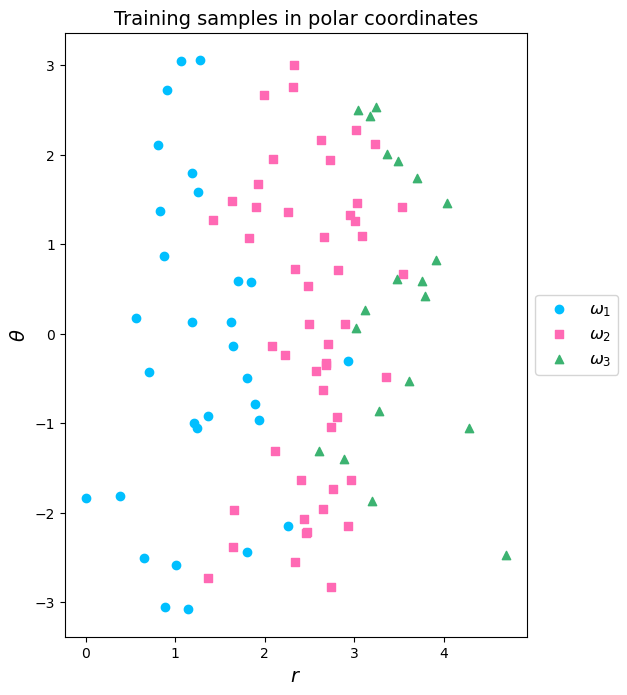

In [42]:
plot_2d_features(transformed_train_data, x_label="$r$", y_label=r"$\theta$", title="Training samples in polar coordinates")

Ditch the dimension of $\theta$, we are now interested in the dimension of $r$ only. The reason is we cannot use the information of $\theta$ to distinguish the samples.

In [43]:
def plot_1d_feature(data, is_sort=False):
    sample_colors = ('deepskyblue', 'hotpink', 'mediumseagreen')
    sample_markers = ('o', 's', '^')
    
    fig, ax = plt.subplots(figsize=(8, 2))

    for c in range(C):
        X = data[c][:, 0]
        if is_sort:
            X = np.sort(X)
            offsets = np.arange(0, len(X), 1) * 0.001
        else:
            offsets = 0
        ax.scatter(X, np.zeros_like(X) + offsets, color=sample_colors[c], edgecolor="black", linewidth=0.4, alpha=0.7, marker=sample_markers[c], label=f"$\omega_{c+1}$")

    ax.get_yaxis().set_ticks([])
    for side in ("left", "right", "top"):
        ax.spines[side].set_visible(False)

    ax.set_title("Training samples in polar coordinates", fontsize=14)
    ax.set_xlabel("$r$", fontsize=14)
    ax.set_ylim(-0.025, 0.08)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})

    plt.show()

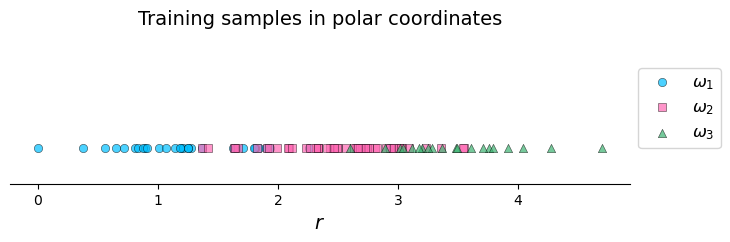

In [44]:
plot_1d_feature(transformed_train_data, is_sort=False)

We only have one axis (1-d) data, but for the sake of visualization, the height of each sample is added. This allows us to see some overlapped samples.

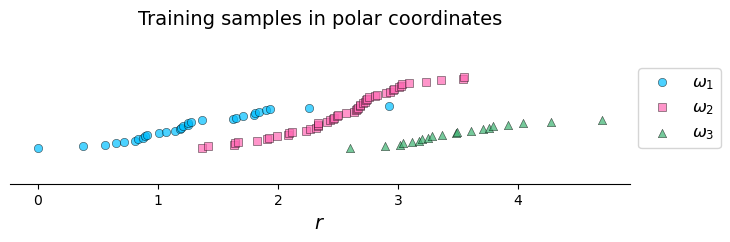

In [45]:
plot_1d_feature(transformed_train_data, is_sort=True)

Assume that each class has the following properties:

- $p(r|\omega_i) \sim \mathcal{N}(\mu_i, \sigma^2)$
- Unknown $\mu_i$

Known variance $\sigma^2 = 0.25$

In [46]:
var = 0.25

Prior $p(\mu_i) \sim \mathcal{N}(\mu_0 = 0, \sigma_0^2 = 100)$ 

In [47]:
prior_mu = [0, 0, 0]
prior_var = [100, 100, 100]

### The Desired Class-conditional Density $p(r | \omega_i, D_i)$

$$
p(r|\omega_i,D_i) = \int p(r|\mu_i) p(\mu_i|D_i) \,d\mu_i
$$

As we know from the question that,
$$
p(r|\mu_i) \sim \mathcal{N}(\mu_i, \sigma^2)
$$

This means that a posteriori density $p(\mu_i | \mathcal{D}_i)$ is the only term that we need to derive.

$$
\begin{align*}
p(\mu | \mathcal{D})
&= \frac{p(\mathcal{D} | \mu) p(\mu)}{\int p(\mathcal{D} | \mu) p(\mu) d\,\mu}\\
&= \frac{\prod_{k=1}^{n} p(\mathcal{x_k} | \mu) p(\mu)}{\int \prod_{k=1}^{n} p(\mathcal{x_k} | \mu) p(\mu) d\,\mu}\\
&= \alpha \prod_{k=1}^{n} p(\mathcal{x_k} | \mu) p(\mu)\\
\end{align*}
$$

We have the constant $\alpha$ that represents a normalization factor (integration in the denominator) since it does not depend on $\mu$.

$$
\begin{align*}
p(\mu | \mathcal{D})
&= \alpha \prod_{k=1}^{n} p(\mathcal{x_k} | \mu) \cdot p(\mu)\\
&= \alpha \prod_{k=1}^{n} \frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{1}{2} \left( \frac{x_k - \mu}{\sigma} \right)^2} \cdot \frac{1}{\sqrt{2 \pi} \sigma_0} e^{-\frac{1}{2} \left( \frac{\mu - \mu_0}{\sigma_0} \right)^2}\\
&= \alpha \frac{1}{\sqrt{2 \pi} \sigma} \frac{1}{\sqrt{2 \pi} \sigma_0} \prod_{k=1}^{n} e^{-\frac{1}{2} \left( \frac{x_k - \mu}{\sigma} \right)^2} \cdot e^{-\frac{1}{2} \left( \frac{\mu - \mu_0}{\sigma_0} \right)^2}\\
&= \alpha' \prod_{k=1}^{n} e^{-\frac{1}{2} \left( \frac{x_k - \mu}{\sigma} \right)^2} \cdot e^{-\frac{1}{2} \left( \frac{\mu - \mu_0}{\sigma_0} \right)^2}\\
&= \alpha' \exp{\left( \sum_{k=1}^{n} -\frac{1}{2} \left( \frac{x_k - \mu}{\sigma} \right)^2 + \left[-\frac{1}{2} \left( \frac{\mu - \mu_0}{\sigma_0} \right)^2 \right] \right)}\\
&= \alpha' \exp{\left( -\frac{1}{2} \left[ \sum_{k=1}^{n} \left( \frac{x_k - \mu}{\sigma} \right)^2 + \left( \frac{\mu - \mu_0}{\sigma_0} \right)^2 \right] \right)}\\
&= \alpha' \exp{\left( -\frac{1}{2} \left[ \sum_{k=1}^{n} \frac{(x_k - \mu)^2}{\sigma^2}  + \frac{(\mu - \mu_0)^2}{\sigma_0^2} \right] \right)}\\
&= \alpha' \exp{\left( -\frac{1}{2} \left[ \sum_{k=1}^{n} \frac{x_k^2 - 2 x_k \mu + \mu^2}{\sigma^2}  + \frac{\mu^2 - 2 \mu \mu_0 + \mu_0^2}{\sigma_0^2} \right] \right)}\\
&= \alpha' \exp{\left( -\frac{1}{2} \left[ \frac{\sum_{k=1}^{n}x_k^2}{\sigma^2} - \frac{\sum_{k=1}^{n} 2 x_k \mu}{\sigma^2} + \frac{n\mu^2}{\sigma^2} + \frac{\mu^2}{\sigma_0^2} - \frac{2 \mu \mu_0}{\sigma_0^2} + \frac{\mu_0^2}{\sigma_0^2} \right] \right)}\\
&= \alpha' \exp{\left( -\frac{1}{2} \left[
\left(
\frac{n\mu^2}{\sigma^2} + \frac{\mu^2}{\sigma_0^2} \right)
+ \left(- \frac{\sum_{k=1}^{n} 2 x_k \mu}{\sigma^2} - \frac{2 \mu \mu_0}{\sigma_0^2} \right)\\
+ \left( \frac{\sum_{k=1}^{n}x_k^2}{\sigma^2} + \frac{\mu_0^2}{\sigma_0^2}
\right)
\right] \right)}\\
&= \alpha'' \exp{\left( -\frac{1}{2} \left[ \left( \frac{n\mu^2}{\sigma^2} + \frac{\mu^2}{\sigma_0^2} \right) + \left(- \frac{\sum_{k=1}^{n} 2 x_k \mu}{\sigma^2} - \frac{2 \mu \mu_0}{\sigma_0^2} \right) \right] \right)}\\
&= \alpha'' \exp{\left( -\frac{1}{2} \left[ \left( \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} \right)\mu^2 - 2 \mu\left(\frac{\sum_{k=1}^{n} x_k}{\sigma^2} + \frac{\mu_0}{\sigma_0^2} \right) \right] \right)}\\
\end{align*}
$$

$p(\mu|\mathcal{D})$ is in the form of an exponential function of $\mu^2$ and $\mu$. If we assume that $p(\mu|\mathcal{D})$ is a normal density as follows:

$$
p(\mu|\mathcal{D}) \sim \mathcal{N}(\mu_n, \sigma_n^2)
$$

where $\mu_n$ is the estimated mean, and $\sigma_n^2$ is the estimated variance.


$$
\begin{align*}
p(\mu | \mathcal{D})
&= \frac{1}{\sqrt{2 \pi} \sigma_n} \exp{\left( -\frac{1}{2} \left( \frac{(\mu - \mu_n)^2}{\sigma_n^2} \right) \right)}\\
&= \frac{1}{\sqrt{2 \pi} \sigma_n} \exp{\left( -\frac{1}{2} \left( \frac{\mu^2 - 2 \mu \mu_n + \mu_n^2}{\sigma_n^2} \right) \right)}\\
&= \frac{1}{\sqrt{2 \pi} \sigma_n} \exp{\left( -\frac{1}{2} \left( \frac{\mu^2}{\sigma_n^2} - \frac{2 \mu \mu_n}{\sigma_n^2} + \frac{\mu_n^2}{\sigma_n^2} \right) \right)}\\
&= \frac{1}{\sqrt{2 \pi} \sigma_n} \exp{\left( -\frac{1}{2} \left( \left[ \frac{1}{\sigma_n^2} \right] \mu^2 - 2 \mu \left[ \frac{\mu_n}{\sigma_n^2} \right] + \frac{\mu_n^2}{\sigma_n^2} \right) \right)}\\
\end{align*}
$$

Thus, we can estimate $\mu_n$ and $\sigma_n^2$ by equating the above equation with a normal distribution.

$$
\begin{align*}
p(\mu | \mathcal{D}) &= \frac{1}{\sqrt{2 \pi} \sigma_n} \exp{\left( -\frac{1}{2} \left( \left[ \frac{1}{\sigma_n^2} \right] \mu^2 - 2 \mu \left[ \frac{\mu_n}{\sigma_n^2} \right] + \frac{\mu_n^2}{\sigma_n^2} \right) \right)}\\
p(\mu | \mathcal{D}) &= \alpha'' \exp{\left( -\frac{1}{2} \left( \left[ \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} \right]\mu^2 - 2 \mu \left[\frac{\sum_{k=1}^{n} x_k}{\sigma^2} + \frac{\mu_0}{\sigma_0^2} \right] \right) \right)}\\
\end{align*}
$$

Comparing the coefficients of the first terms in the exponential ($\mu_n^2$ and $\mu^2$) between left hand side and right hand side gives us:

$$
\begin{align*}
\frac{1}{\sigma_n^2} &= \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2}\\
\frac{1}{\sigma_n^2} &= \frac{n \sigma_0^2 + \sigma^2}{\sigma^2 \sigma_0^2}\\
\sigma_n^2 &= \frac{\sigma^2 \sigma_0^2}{n \sigma_0^2 + \sigma^2}
\end{align*}
$$

In [48]:
bayes_var = np.zeros(C)

for c in range(C):
    X = transformed_train_data[c][:, 0]
    n = len(X)
    bayes_var[c] = (var * prior_var[c]) / ((n * prior_var[c]) + var)
    show(r'\sigma^2_'+str(c+1), bayes_var[c], precision=4)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can also compare the coefficients of the second terms in the exponential ($\mu_n$ and $\mu$) between left hand side and right hand side. This gives us:

$$
\begin{align*}
\frac{\mu_n}{\sigma_n^2}
&= \frac{\sum_{k=1}^{n} x_k}{\sigma^2} + \frac{\mu_0}{\sigma_0^2}\\
&= \frac{1}{\sigma^2} \sum_{k=1}^{n} x_k + \frac{\mu_0}{\sigma_0^2}\\
&= \frac{1}{\sigma^2} \frac{n}{n} \sum_{k=1}^{n} x_k + \frac{\mu_0}{\sigma_0^2}\\
&= \frac{1}{\sigma^2} n \left[ \frac{1}{n} \sum_{k=1}^{n} x_k \right] + \frac{\mu_0}{\sigma_0^2}\\
&= \frac{1}{\sigma^2} n \bar{x_n} + \frac{\mu_0}{\sigma_0^2}\\
\frac{\mu_n}{\sigma_n^2}
&= \frac{n}{\sigma^2} \bar{x_n} + \frac{\mu_0}{\sigma_0^2}\\
\mu_n
&= \sigma_n^2 \left( \frac{n}{\sigma^2} \bar{x_n} + \frac{\mu_0}{\sigma_0^2} \right)\\
&= \frac{n \sigma_n^2}{\sigma^2} \bar{x_n} + \frac{\sigma_n^2}{\sigma_0^2} \mu_0 \\
&= \frac{n}{\sigma^2} \left[ \frac{\sigma^2 \sigma_0^2}{n \sigma_0^2 + \sigma^2} \right] \bar{x_n} + \frac{1}{\sigma_0^2} \left[ \frac{\sigma^2 \sigma_0^2}{n \sigma_0^2 + \sigma^2} \right] \mu_0 \\
\mu_n
&= \frac{n \sigma_0^2}{n \sigma_0^2 + \sigma^2} \bar{x_n} + \frac{\sigma^2}{n \sigma_0^2 + \sigma^2} \mu_0 \\
\end{align*}
$$

where the sample mean $\bar{x}_n$ is:

$$
\bar{x}_n = \frac{1}{n} \sum_{k=1}^{n} x_k
$$

Based on the derived $\sigma_n^2$, we can arrive at a final form of computing $\mu_n$ without the dependency of $\sigma_n^2$. 

In [49]:
def estimate_bayes_mu(X, var, prior_mu, prior_var):
    n = len(X)
    x_bar = compute_mean(X)
    bayes_mu = ((n * prior_var) / ((n * prior_var) + var)) * x_bar
    bayes_mu += (var / ((n * prior_var) + var)) * prior_mu
    return bayes_mu

In [50]:
bayes_mu = np.zeros(C)

for c in range(C):
    X = transformed_train_data[c][:, 0]
    bayes_mu[c] = estimate_bayes_mu(X, var, prior_mu[c], prior_var[c])
    show(r'\mu_' + str(c+1), bayes_mu[c])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Next, the desired class-conditional density $p(r|\mathcal{D})$ will be derived based on the a posteriori density $p(\mu|\mathcal{D})$.

<u>Note</u>: Whereas we are focusing on $p(r|\mathcal{D})$, its true form is actually $p(r|\omega_i, \mathcal{D_i})$. We just drop the class distinctions for simplicity.
- $\mathcal{D}$ is the dataset of a class. It can be $\mathcal{D}_i$ where $i = 1, \dots, C$.

As we use both the prior probability $p(\mu_i | \mathcal{D})$ and the probability density $p(r | \mu_i)$, we arrive at:
$$
\begin{align*}
p(r|\mathcal{D}) 
&= \int p(r|\mu_i) \cdot p(\mu_i|\mathcal{D}) \,d\mu_i\\
&= \int \frac{1}{\sqrt{2 \pi} \sigma} \exp \left[ -\frac{1}{2} \left( \frac{x - \mu}{\sigma} \right)^2 \right]
\cdot \int \frac{1}{\sqrt{2 \pi} \sigma_n} \exp \left[ -\frac{1}{2} \left( \frac{\mu - \mu_n}{\sigma_n} \right)^2 \right] \,d\mu\\
\end{align*}
$$

We pull the terms that do not relate to $\mu$ out, we get

$$
\begin{align*}
p(r|\mathcal{D}) 
&= \frac{1}{2 \pi \sigma \sigma_n} \exp \left[ -\frac{1}{2} \frac{(x - \mu_n)^2}{\sigma^2 + \sigma_n^2} \right]
\cdot \int \exp \left[ -\frac{1}{2} \frac{\sigma^2 + \sigma_n^2}{\sigma^2 \sigma_n^2} \left( \mu - \frac{\sigma_n^2 x + \sigma^2 \mu_n}{\sigma^2 + \sigma_n^2} \right)^2 \right] \,d\mu\\
\end{align*}
$$

From the first term of the above equation, we can see that $p(r|\mathcal{D})$ can be viewed as an approximate normal distribution where $\mu_n$ is the mean, and $\sigma^2 + \sigma_n^2$ is the variance.

$$
p(r|\mathcal{D}) \sim \mathcal{N}(\mu_n, \sigma^2 + \sigma_n^2)
$$

In [51]:
def normal_distribution(x, mu, var):
    return np.exp(-0.5 * ((x - mu)**2 / var)) / np.sqrt(2 * np.pi * var)

In [52]:
a_posteriori_densities = []

x_values = np.arange(0, 5.001, 0.001)
for c in range(C):
    y_values = [normal_distribution(x, bayes_mu[c], var + bayes_var[c]) for x in x_values]
    y_values /= np.sum(y_values)
    a_posteriori_densities.append(y_values)

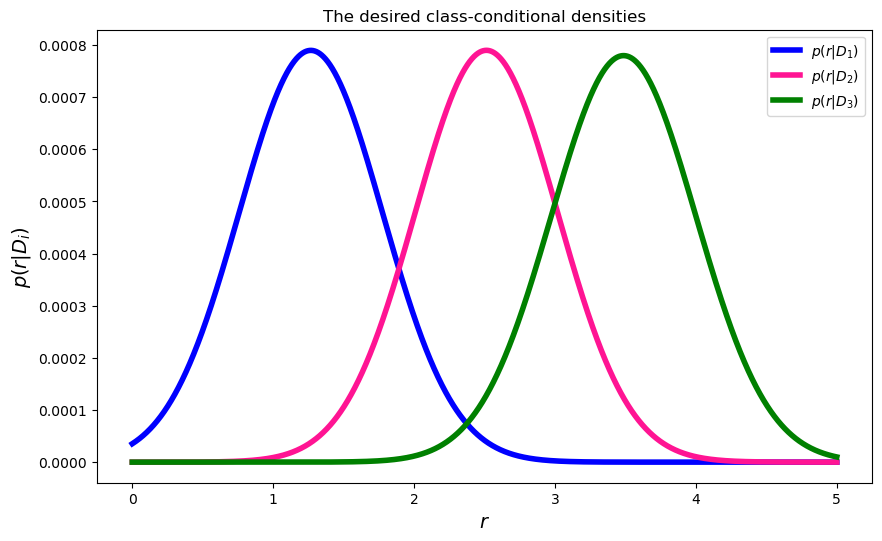

In [53]:
mean_colors = ('blue', 'deeppink', 'green')

fig, ax = plt.subplots(figsize=(10, 6))

for c, y_values in enumerate(a_posteriori_densities):
    ax.plot(x_values, y_values, linewidth=4, color=mean_colors[c], label=r"$p(r|D_" + str(c+1) + ")$")

ax.set_xlabel(r"$r$", size=14)
ax.set_ylabel(r"$p(r|D_i)$", size=14)
ax.set_title("The desired class-conditional densities")
ax.legend()

plt.show()

### Classification

We use the estimated class-conditional densities to classify the test data. Again, the class $i$ with the maximum class-conditional densities at $r$ will be selected.

$$
\hat{y}(r) = \operatorname*{argmax}_{i} p(r|\omega_i, \mathcal{D}_i)
$$

### Confusion Matrix

In [54]:
bayes_confusion_matrix = np.zeros((C, C))

for c in range(C):
    for x, _ in transformed_test_data[c]:
        class_conditional_densities = np.zeros(C)
        for i in range(C):
            class_conditional_densities[i] = normal_distribution(x, bayes_mu[i], var + bayes_var[i])
        pred_class = np.argmax(class_conditional_densities)
        bayes_confusion_matrix[c][pred_class] += 1

In [55]:
bayes_confusion_matrix

array([[66.,  4.,  0.],
       [10., 67., 17.],
       [ 0.,  3., 43.]])

| | (predicted) 1 | (predicted) 2 | (predicted) 3 |
| :-: | :-: | :-: | :-: |
|<b>(actual) 1</b>|66|4|0|
|<b>(actual) 2</b>|10|67|17|
|<b>(actual) 3</b>|0|3|43|

<center>Table 3: Confusion matrix of the model with the estimated parameter $\mu_i$ using Bayesian Estimation</center>

According to the confusion matrix shown above, most of the samples are classified correctly. They are placed in the diagonal of the confusion matrix. On the other hand, there are misclassified samples that are off-diagonal of the confusion matrix.

- 4 samples are classified as class 2 but actually they are from class 1
- 10 samples are classified as class 1 but actually they are from class 2
- 17 samples are classified as class 3 but actually they are from class 2
- 3 samples are classified as class 2 but actually they are from class 3

In [56]:
bayes_accuracy = bayes_confusion_matrix.trace() / bayes_confusion_matrix.sum()
bayes_error = 1 - bayes_accuracy

show('\mathrm{Test\ Accuracy}', bayes_accuracy)
show('\mathrm{Test\ Error}', bayes_error)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This time, the test accuracy based on the estimated parameters $\mu_i$ using Bayesian Estimation can attain $83.81\%$ test accuracy. The test error is then equal to $16.19\%$.

- Comparing this to the previous MLE method with **biased** covariance matrices, BE provides us a better test accuracy by a margin of $8.1\%$.
- Comparing this to the previous MLE method with **unbiased** covariance matrices, BE provides us a better test accuracy by a margin of $7.62\%$.